In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib inline

In [2]:
def generate_linear(n=100):
    pts = np.random.uniform(0, 1, (n, 2))
    inputs = []
    labels = []
    for pt in pts:
        inputs.append([pt[0], pt[1]])
        distance = (pt[0] - pt[1])/1.414
        if pt[0] > pt[1]:
            labels.append(0)
        else:
            labels.append(1)
    
    return np.array(inputs), np.array(labels).reshape(n, 1)

In [3]:
def generate_XOR_easy():
    inputs = []
    labels = []
    
    for i in range(11):
        inputs.append([0.1 * i, 0.1 * i])
        labels.append(0)

        if 0.1 * i == 0.5:
            continue

        inputs.append([0.1 * i, 1 - 0.1*i])
        labels.append(1)        

    return np.array(inputs), np.array(labels).reshape(21, 1)

In [4]:
def plot_data(X, y, pred_y, save_img_name):
    print("Acc: ", 1 - np.mean(abs(y - pred_y)))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 10))
    color_real = ['red' if l == 0 else 'green' for l in y]
    color_pred = ['red' if l == 0 else 'green' for l in pred_y]
    
    ax[0].scatter(X[:, 0], X[:, 1], color=color_real)
    ax[0].set_aspect("equal")
    ax[0].title.set_text("real")

    ax[1].scatter(X[:, 0], X[:, 1], color=color_pred)
    ax[1].title.set_text("predict")
    ax[1].set_aspect("equal")
    plt.savefig(save_img_name)
    plt.show()
    plt.clf()

In [5]:
class Model():
    # input is 3d(x, y coordinate + 1 for bias), output is 1d
    # 2 hidden layer, 2 neurons for each
    class Layer():
        def __init__(self, size):
            self.d_a_hat = 0
            self.d_a = 0
            self.W = np.random.random(size) * np.sqrt(2 / size[1])
            self.b = np.zeros((1, size[1]))
            self.a_hat = 0
            self.Wm = np.zeros(size)
            self.bm = np.zeros((1, size[1]))
                        
    def __init__(self):
        self.layer = []
    
    def add_layer(self, size):
        l = self.Layer(size)
        self.layer.append(l)
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def derivative_sigmoid(self, x):
        return np.multiply(x, 1.0 - x)
    
    def cal_loss(self, y, pred_y):
        # using cross entropy
#         return (1/2) * np.mean(sum(pow(pred_y - y, 2)))
        return np.mean(-(y * np.log(pred_y) + (1 - y) * np.log(1 - pred_y)))
    
    
    def derivative_loss(self, y, pred_y, batch_size):
#         return (pred_y - y) / batch_size
        return ((-y / pred_y) + (1 - y) / (1 - pred_y))/batch_size
    
    def update_W(self, x, y, pred_y, lr, batch_size):
        num_layer = len(self.layer)
        for i in range(num_layer)[::-1]:
            cur_layer = self.layer[i]
            if i == num_layer - 1:
                cur_layer.d_a_hat = self.derivative_loss(y, pred_y, batch_size)
            else:
                cur_layer.d_a_hat = self.layer[i+1].d_a @ self.layer[i+1].W.T
            cur_layer.d_a = cur_layer.d_a_hat * self.derivative_sigmoid(cur_layer.a_hat)
                         
        for i in range(num_layer):
            cur_layer = self.layer[i]
            if i == 0:
                grad = -lr * np.atleast_2d(x).T @ cur_layer.d_a
            else:
                grad = -lr * self.layer[i-1].a_hat.T @ cur_layer.d_a
            cur_layer.W += grad + cur_layer.Wm
            cur_layer.Wm = cur_layer.Wm * 0.99 + grad * 0.01
            
            grad_b = -lr * (np.mean(cur_layer.d_a, axis=0))
            cur_layer.b += grad_b + cur_layer.bm
            cur_layer.bm = cur_layer.bm * 0.99 + grad_b * 0.01
            
    
    def preprocess_x(self, X_train):
        # add bias term
        X_train = np.hstack((X_train, np.ones(X_train.shape[0]).reshape(-1, 1)))
        return X_train
        
    def train(self, X_train, y_train, lr, batch_size=5, iteration=100):        
        loss_acc = []
        batch = list(range(0, X_train.shape[0], batch_size))
        if batch[-1] != X_train.shape[0]:
            batch.append(X_train.shape[0])
        
        for i in range(iteration):
            pred_y = []
            for k in range(len(batch)-1):
                x = X_train[batch[k]:batch[k+1]]
                y = y_train[batch[k]:batch[k+1]]
                in_data = np.atleast_2d(x)
                for j in range(len(self.layer)):
                    self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                    in_data = self.layer[j].a_hat
                        
                y_hat = in_data
                loss = self.cal_loss(y, y_hat)
                self.update_W(x, y, y_hat, lr, batch_size)
                pred_y.extend(y_hat)
            
            pred_y = np.array(pred_y)
            loss = np.mean(self.cal_loss(y_train, pred_y))
            loss_acc.append(loss)
            if i % 5000 == 0:
                print("epoch", i, ":", loss)
                
        return loss_acc
        
    def predict(self, X):
        pred_y = []
        for x in X:
            in_data = np.atleast_2d(x)
            for j in range(len(self.layer)):
                self.layer[j].a_hat = self.sigmoid((in_data @ self.layer[j].W) + self.layer[j].b)
                in_data = self.layer[j].a_hat

            pred_y.extend(in_data)
        return np.round(np.array(pred_y)), np.array(pred_y)

In [6]:
def shuffle(X, y):
    p = np.random.permutation(X.shape[0])
    return X[p], y[p]

Linear data:
epoch 0 : 0.8569987224944816
epoch 5000 : 0.016527634409580425
epoch 10000 : 0.010276714667185514
epoch 15000 : 0.007408436480596594
prediction:
 [[9.99998391e-01 1.79913670e-07 9.99998519e-01 1.78999090e-07]
 [1.79446390e-07 9.99997973e-01 9.99998525e-01 1.79247848e-07]
 [9.99998526e-01 1.77780612e-07 1.80622992e-07 1.78240905e-07]
 [9.99998526e-01 1.77727745e-07 9.99998520e-01 9.99876099e-01]
 [9.99998516e-01 9.99998525e-01 9.99998526e-01 2.16079706e-07]
 [1.94552939e-07 9.99998514e-01 3.03942905e-06 9.99998523e-01]
 [9.99995119e-01 1.79926903e-07 2.23416715e-07 1.77614792e-07]
 [1.77415657e-07 2.40870466e-01 1.27855843e-06 1.77513595e-07]
 [9.99998417e-01 1.77422342e-07 9.99998518e-01 2.15903804e-06]
 [2.32661985e-07 1.07822133e-05 9.04784169e-01 9.99998316e-01]
 [9.99998526e-01 6.04402272e-05 9.77782090e-01 9.99998525e-01]
 [1.85538578e-07 2.48594699e-07 1.78085434e-07 2.42340170e-07]
 [9.99994024e-01 1.77844365e-07 1.98013010e-06 9.99998518e-01]
 [9.99998525e-01 9.999

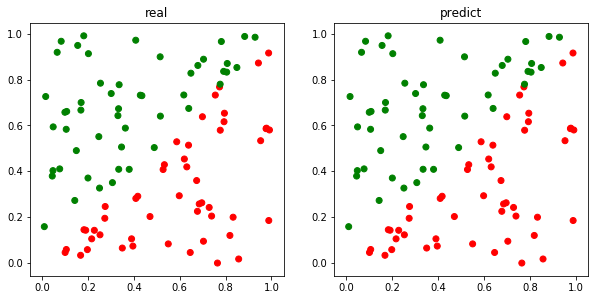

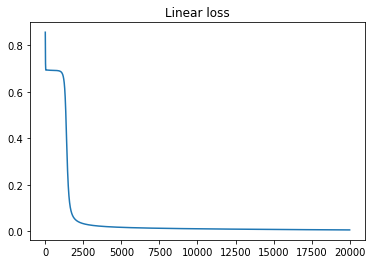

<Figure size 432x288 with 0 Axes>

In [7]:
print("Linear data:")
lr = 0.3
batch_size=100
X, y = generate_linear()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 2))
m.add_layer((2, 2))
m.add_layer((2, 1))
loss = m.train(X, y, lr, batch_size, iteration=20000)
pred_y, pred_y_raw = m.predict(X)
print("prediction:\n", pred_y_raw.reshape(-1, 4))
plot_data(X, y, pred_y, "linear_pred.png")
plt.plot(loss)
plt.title("Linear loss")
plt.savefig("linear_loss.png")
plt.show()
plt.clf()

XOR data:
epoch 0 : 1.0632285605004856
epoch 5000 : 0.6919583146145778
epoch 10000 : 0.06817689486684904
epoch 15000 : 0.001666529993232572
epoch 20000 : 0.0006893343787855975
epoch 25000 : 0.0004179469109690259
epoch 30000 : 0.0002949950931110586
epoch 35000 : 0.00022591803898841916
epoch 40000 : 0.00018204537443212198
epoch 45000 : 0.00015187423069284534
epoch 50000 : 0.00012993444393866708
epoch 55000 : 0.00011330659624200696
epoch 60000 : 0.00010029634460964113
epoch 65000 : 8.985551965382377e-05
epoch 70000 : 8.130223826867964e-05
epoch 75000 : 7.417447616850633e-05
epoch 80000 : 6.814847344957334e-05
epoch 85000 : 6.299085559360556e-05
epoch 90000 : 5.852929921381961e-05
epoch 95000 : 5.4633889433174955e-05
prediction:
 [9.99999371e-01 9.99999339e-01 9.99998960e-01 9.99999368e-01
 9.99714798e-01 3.87995574e-06 4.70567051e-07 9.99998969e-01
 3.57600703e-08 2.17751284e-04 7.32746510e-08 9.99714817e-01
 2.21642211e-06 9.99999365e-01 2.39229251e-05 8.44294967e-06
 1.11633680e-05 9.99

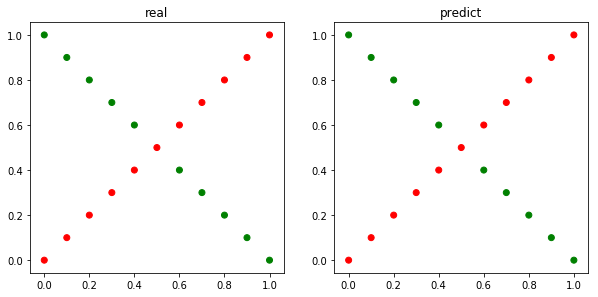

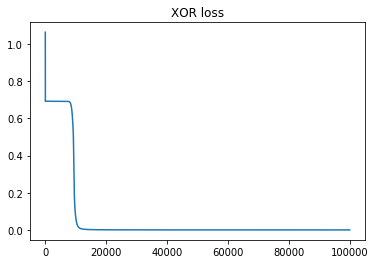

<Figure size 432x288 with 0 Axes>

In [8]:
print("XOR data:")
lr = 0.3
X, y = generate_XOR_easy()
X, y = shuffle(X, y)
m = Model()
m.add_layer((2, 3))
m.add_layer((3, 3))
m.add_layer((3, 1))
loss = m.train(X, y, lr, batch_size=21, iteration=100000)
pred_y, pred_y_raw = m.predict(X)
print("prediction:\n", pred_y_raw.flatten())
plot_data(X, y, pred_y, "XOR_pred.png")
plt.plot(loss)
plt.title("XOR loss")
plt.savefig("XOR_loss.png")
plt.show()
plt.clf()